In [19]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn.metrics as metrics
%matplotlib inline

In [20]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [ ]:
is_test = True

In [21]:
root ='../Data/INRIAPerson/'
test = os.path.join(root, 'test_64x128_H96') 

In [22]:
# Operating with images
def get_image_paths(folder, extension):
  image_paths = []
  for x in os.listdir(folder):
    x_path = os.path.join(folder, x)
    if os.path.splitext(x_path)[1] in extension:
      image_paths.append(x_path)
  return image_paths


def load_data_and_labels(folder, label):
  images = []
  labels = []
  image_paths = get_image_paths(folder, ['.jpg', '.png', '.jpeg'])
  for image_path in image_paths:
    im = cv2.imread(image_path, cv2.IMREAD_COLOR)
    images.append(im)
    labels.append(label)
  return images, labels

In [23]:
# compute HOG features for given images
def get_hog_features(hog, images):
  hog_features = []
  for image in images:
    hog_feature = hog.compute(image)
    hog_features.append(hog_feature)
  return hog_features

# Convert HOG descriptors to format recognized by SVM
def prepare_for_svm(hog_features):
  featureVectorLength = len(hog_features[0])
  print("Feature vector: ", featureVectorLength)
  data = np.float32(hog_features).reshape(-1, featureVectorLength)
  print("Data: ", data.shape)
  return data

def get_svm_detector_for_hog(model_path, hog):
  svm = cv2.ml.SVM_load(model_path)
  sv = svm.getSupportVectors()
  rho,_ ,_ = svm.getDecisionFunction(0)
  svm_detector = np.zeros(sv.shape[1] + 1, dtype=sv.dtype)
  svm_detector[:-1] = -sv[:]
  svm_detector[-1] = rho
  return svm_detector


In [24]:
window = (64, 128)
block = (16, 16)
block_stride = (8, 8)
cell = (8, 8)
n_bins = 9
derivative_aperature = 1
sigma = -1
norm_type = 0
threshold = 0.2
gamma_correction = True
nlevels = 64
gradient = False

# Initialize HOG
hog = cv2.HOGDescriptor(window, block, block_stride,
                      cell, n_bins,derivative_aperature,
                      sigma, norm_type, threshold, 
                      gamma_correction, nlevels,gradient)

Feature vector:  3780
Data:  (1126, 3780)
label -- 1:1065, -1:61
TP: 1065, FP: 61, Total: 1126, error: 5.41740674955595
Feature vector:  3780
Data:  (4530, 3780)
label -- 1:17, -1:4513
TN: 4513, FN: 17, Total: 4530, error: 0.37527593818984545
Precision: 94.58259325044405, Recall: 98.42883548983365


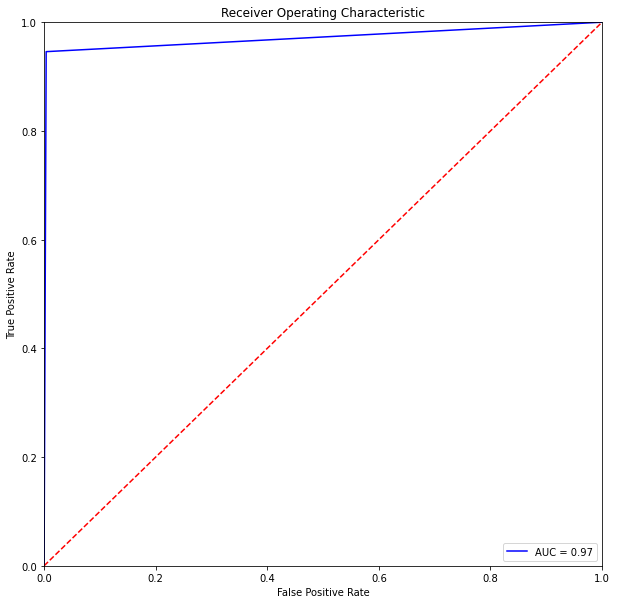

In [25]:
# Testing model with data from test set 
def evaluate(svm, samples, labels):
  labels = labels[:, np.newaxis]
  pred = svm.predict(samples)[1]
  correct = np.sum((labels == pred))
  err = (labels != pred).mean()
  print('label -- 1:{}, -1:{}'.format(np.sum(pred == 1), 
          np.sum(pred == -1)))
  return correct, err * 100, pred

if is_test:
    model = cv2.ml.SVM_load('../model/pedestrian.yml')
    test_pos = os.path.join(test, 'posPatches')
    test_neg = os.path.join(test, 'negPatches')
    # We will follow the same flow to prepare data as we did for training images.
    # Label 1 for positive images and -1 for negative images
    test_pos_images, test_pos_labels = load_data_and_labels(test_pos, 1)
    test_neg_images, test_neg_labels = load_data_and_labels(test_neg, -1)

    # Compute HOG features for images
    hog_post_test = get_hog_features(hog, np.array(test_pos_images))
    test_pos_data = prepare_for_svm(hog_post_test)
    
    pos_correct, pos_err, pos_pred = evaluate(model, test_pos_data, 
                                       np.array(test_pos_labels))

    tp = pos_correct
    fp = len(test_pos_labels) - pos_correct
    print('TP: {}, FP: {}, Total: {}, error: {}'
            .format(tp, fp, len(test_pos_labels), pos_err))

    hog_neg_test = get_hog_features(hog, np.array(test_neg_images))
    test_neg_data = prepare_for_svm(hog_neg_test)
    neg_correct, neg_err, neg_pred = evaluate(model, test_neg_data, 
                                       np.array(test_neg_labels))

    # Calculate True and False Negatives
    tn = neg_correct
    fn = len(test_neg_data) - neg_correct
    print('TN: {}, FN: {}, Total: {}, error: {}'
            .format(tn, fn, len(test_neg_labels), neg_err))
    # Calculate Precision and Recall
    precision = tp * 100 / (tp + fp)
    recall = tp * 100 / (tp + fn)
    print('Precision: {}, Recall: {}'.format(precision, recall))

    pos_pred = [i for sublist in pos_pred.tolist() for i in sublist]
    neg_pred = [i for sublist in neg_pred.tolist() for i in sublist]
    for i in range(len(test_neg_labels)):
        test_pos_labels.append(test_neg_labels[i])
        pos_pred.append(neg_pred[i])
    test_labels = test_pos_labels
    test_pred = pos_pred

    fpr, tpr, threshold = metrics.roc_curve(test_labels, test_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


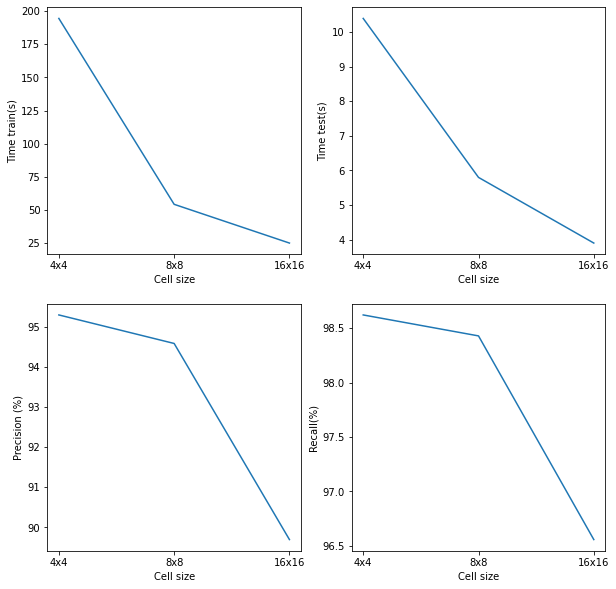

In [26]:
import pandas as pd 
import seaborn as sns
data = {'Time train': [194.5, 54.4, 25.2], 'Time test': [10.4, 5.8, 3.9], 'Precision': [95.2931, 94.5826, 89.6980
], 'Recall':[98.6213, 98.4288, 96.5583]}
df = pd.DataFrame(data, index = ['4x4', '8x8', '16x16'])  
plt.subplot(221)
plt.plot(df.index, df['Time train'])
plt.ylabel('Time train(s)')
plt.xlabel('Cell size')
plt.subplot(222)
plt.plot(df.index, df['Time test'])
plt.ylabel('Time test(s)')
plt.xlabel('Cell size')
plt.subplot(223)
plt.plot(df.index, df['Precision'])
plt.xlabel('Cell size')
plt.ylabel('Precision (%)')
plt.subplot(224)
plt.plot(df.index, df['Recall'])
plt.xlabel('Cell size')
plt.ylabel('Recall(%)')
plt.show()

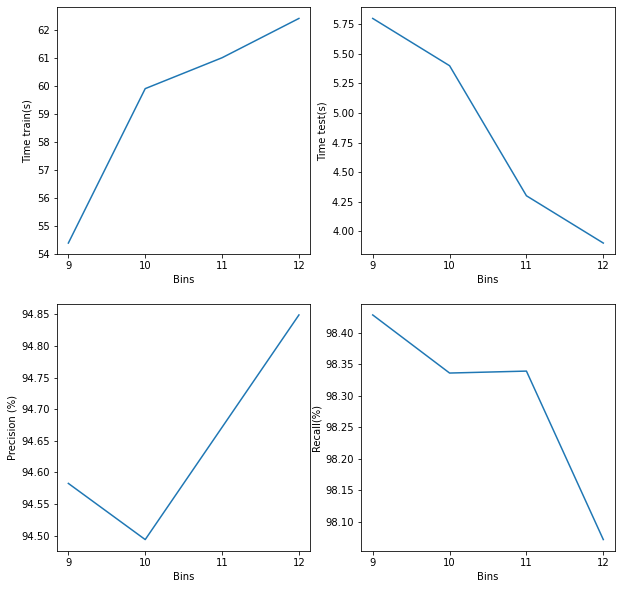

In [27]:
data2 = {'Time train': [54.4, 59.9, 61, 62.4], 'Time test': [5.8, 5.4, 4.3,3.9], 'Precision': [94.5826, 94.4938, 94.6714, 94.8490
], 'Recall':[98.4288, 98.3364, 98.3395, 98.0716]}
df = pd.DataFrame(data2, index = ['9', '10', '11', '12'])  
plt.subplot(221)
plt.plot(df.index, df['Time train'])
plt.ylabel('Time train(s)')
plt.xlabel('Bins')
plt.subplot(222)
plt.plot(df.index, df['Time test'])
plt.ylabel('Time test(s)')
plt.xlabel('Bins')
plt.subplot(223)
plt.plot(df.index, df['Precision'])
plt.xlabel('Bins')
plt.ylabel('Precision (%)')
plt.subplot(224)
plt.plot(df.index, df['Recall'])
plt.xlabel('Bins')
plt.ylabel('Recall(%)')
plt.show()

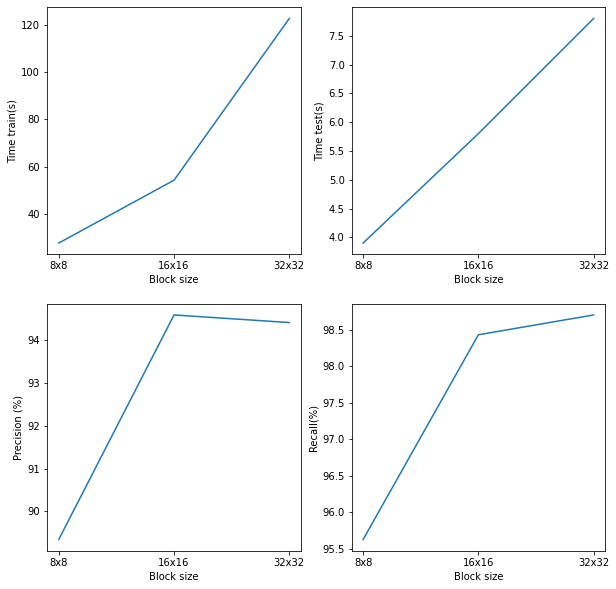

In [28]:
data3 = {'Time train': [27.9, 54.4, 122.6], 'Time test': [3.9, 5.8, 7.8], 'Precision': [89.3428, 94.5826, 94.4050
], 'Recall':[95.6274, 98.4288, 98.7001]}
df = pd.DataFrame(data3, index = ['8x8', '16x16', '32x32'])  
plt.subplot(221)
plt.plot(df.index, df['Time train'])
plt.ylabel('Time train(s)')
plt.xlabel('Block size')
plt.subplot(222)
plt.plot(df.index, df['Time test'])
plt.ylabel('Time test(s)')
plt.xlabel('Block size')
plt.subplot(223)
plt.plot(df.index, df['Precision'])
plt.xlabel('Block size')
plt.ylabel('Precision (%)')
plt.subplot(224)
plt.plot(df.index, df['Recall'])
plt.xlabel('Block size')
plt.ylabel('Recall(%)')
plt.show()